# Introduction
In my project `Happify` I tried out KMeans and DBSCAN for clustering Spotify tracks.
It was a fun project, but it turned out to be hard to evaluate the results of different clustering methods in a high number of dimensions.

I would like to try out more clustering methods and quickly evaluate them by applying them to two dimesnional data with clear structures.
Some inspiration from sklearn can be found [here](http://scikit-learn.org/stable/modules/clustering.html).

I will be opting to use sklearn for this task, as it will allow me to quikcly try out many different clustering methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Setting up some training examples

## Example A - Perfect Circles

In [235]:
import math

r1 = 1
r2 = 2
r3 = 3

inner = np.array([np.array([math.sin(phi) * r1, math.cos(phi) * r1]) for phi in np.linspace(0, 2 * math.pi, 20)])
middle = np.array([np.array([math.sin(phi) * r2, math.cos(phi) * r2]) for phi in np.linspace(0, 2 * math.pi, 40)])
outer = np.array([np.array([math.sin(phi) * r3, math.cos(phi) * r3]) for phi in np.linspace(0, 2 * math.pi, 60)])

example_a = np.concatenate([inner, middle, outer])

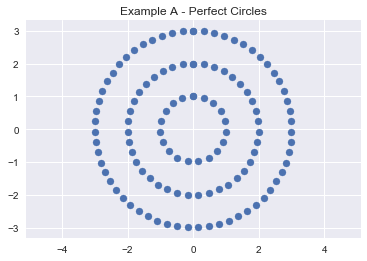

In [236]:
f = plt.scatter(*example_a.T)
plt.axis('equal')
f.axes.set_title('Example A - Perfect Circles')

Thee perfect circles enclosing each other. 
Imposible to solve using a method like KMeans, should be easy to tune DBSCAN to solve it.

## Example B - Noisy Circles

In [49]:
import random

In [85]:
def noisy_circle(radius, points, center_x = 0, center_y = 0, noise_strength = .5 ):
    max_radius_noise = noise_strength * radius
    max_angle_noise = noise_strength * math.pi
    
    return np.array([np.array([center_x + math.sin(phi + random.random()*max_angle_noise) * (radius + random.random()*max_radius_noise), center_y + math.cos(phi + random.random()*max_angle_noise) * (radius + random.random()*max_radius_noise)]) for phi in np.linspace(0, 2 * math.pi, points)])

In [104]:
def noisy_circle(radius, points, center_x = 0, center_y = 0, noise_strength = .5 ):
    max_radius_noise = noise_strength * radius
    
    return np.array([np.array([center_x + math.sin(phi) * r, center_y + math.cos(phi) * r]) 
                 for phi, r in [(2 * math.pi * random.random(), radius + max_radius_noise * (.5 - random.random())) for i in range(points)]])

In [237]:
import random
random.seed(10)

r1 = 1
r2 = 2
r3 = 3

inner = noisy_circle(r1, 100, noise_strength=.2)
middle = noisy_circle(r2, 200, noise_strength=.2) 
outer = noisy_circle(r3, 300, noise_strength=.2)
example_b = np.concatenate([inner, middle, outer])

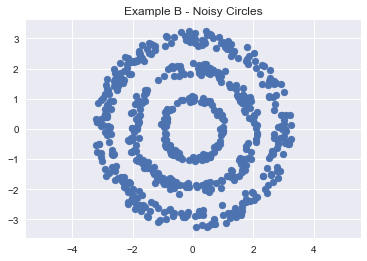

In [238]:
f = plt.scatter(*example_b.T)
plt.axis('equal')
f.axes.set_title('Example B - Noisy Circles')

Three noisy, more dense, circles enclosing eachother.

The outermost circle is pretty close to the middle one at some points, this could make this task more challenging than Example A. 

## Example C - Balls

In [113]:
def ball(radius, points, center_x, center_y):
    return np.array([np.array([center_x + math.sin(phi) * r, center_y + math.cos(phi) * r]) 
                 for phi, r in [(2 * math.pi * random.random(), radius * random.random() ) for i in range(points)]])

In [125]:
ball_a = ball(1, 100, 0, 0)
ball_b = ball(1.5, 100, 3, 1)
ball_c = ball(1, 100, -1, 2)


example_c = np.concatenate([ball_a, ball_b, ball_c])

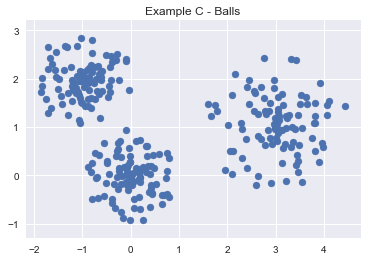

In [126]:
f = plt.scatter(*example_c.T)
plt.axis('equal')
f.axes.set_title('Example C - Balls')

Three clusters, one less dense.

The two dense clusters lie pretty close together, this could possibly lead to problems when tuning DBSCAN as the epsilon required to connect all points in the larger cluster might also be enough to connect the two smaller clusters. Tricky!

As the points in each cluster have uniform distribution their mean should all be close to their centers, so KMeans should perform well with K set to 3!

## Example D - Elipses

In [161]:
def elipse(x_rad, y_rad,  points, center_x, center_y, rotation):
    xy_ratio = x_rad / y_rad
    c, s = math.cos(rotation), math.sin(rotation)
    rotation_mat = np.array(((c, - s), (s, c)))
    
    return np.array([(center_x , center_y) + np.dot(np.array([math.sin(phi) * r * xy_ratio, math.cos(phi) * r]), rotation_mat)
                 for phi, r in [(2 * math.pi * random.random(), x_rad * random.random() ) for i in range(points)]])

In [172]:
elipse_a = elipse(1, .25, 100, 0, 0, math.pi/4)
elipse_b = elipse(1, .25, 100, 3, 1, math.pi/4)
elipse_c = elipse(1, .5, 100, -5, 0, math.pi/4)


example_d = np.concatenate([elipse_a, elipse_b, elipse_c])

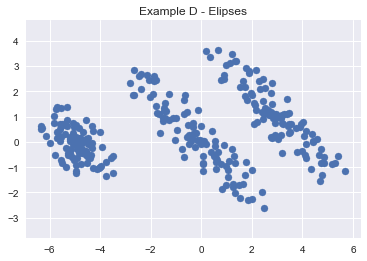

In [173]:
f = plt.scatter(*example_d.T)
plt.axis('equal')
f.axes.set_title('Example D - Elipses')

This one wont be possible to cluster for KMeans, and the proximity of the two left elipses could possible be challenging for other clustering methods as well.

In [239]:
examples = [example_a, example_b, example_c, example_d]

# KMeans
All example have 3 natural clusters. Almost seems like constructed example huh?

In [240]:
from sklearn.cluster import KMeans

In [241]:
model = KMeans(3)

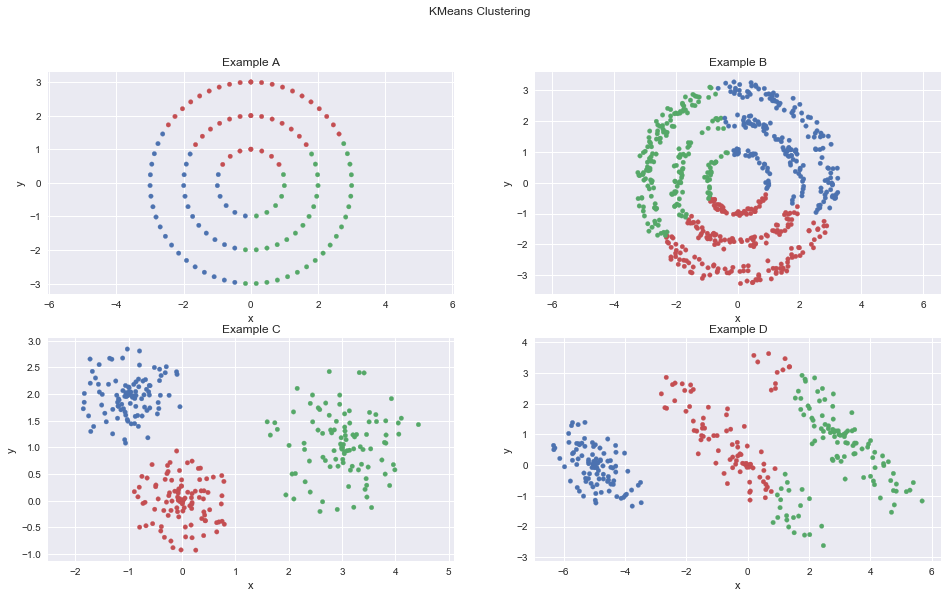

In [242]:
f, ax = plt.subplots(2, 2, figsize=(16,9))
ax = ax.flatten()

colors = sns.color_palette()

for i, example in enumerate(examples):
    labels = model.fit_predict(example)
    df = pd.DataFrame(example, columns=['x', 'y'])
    df['label'] = labels
    df.plot('x', 'y', kind = 'scatter', ax=ax[i], c = df['label'].apply(lambda x: colors[x]))
    ax[i].axis('equal')
    ax[i].set_title("Example {}".format("ABCD"[i]))

f.suptitle("KMeans Clustering")

We see the expected problems with KMeans. It selects circular regions to be clusters, so it strugles with the enclosed circles and the parallel elipses.

# DBSCAN

In [243]:
from sklearn.cluster import DBSCAN

In [246]:
model = DBSCAN(eps=.4)

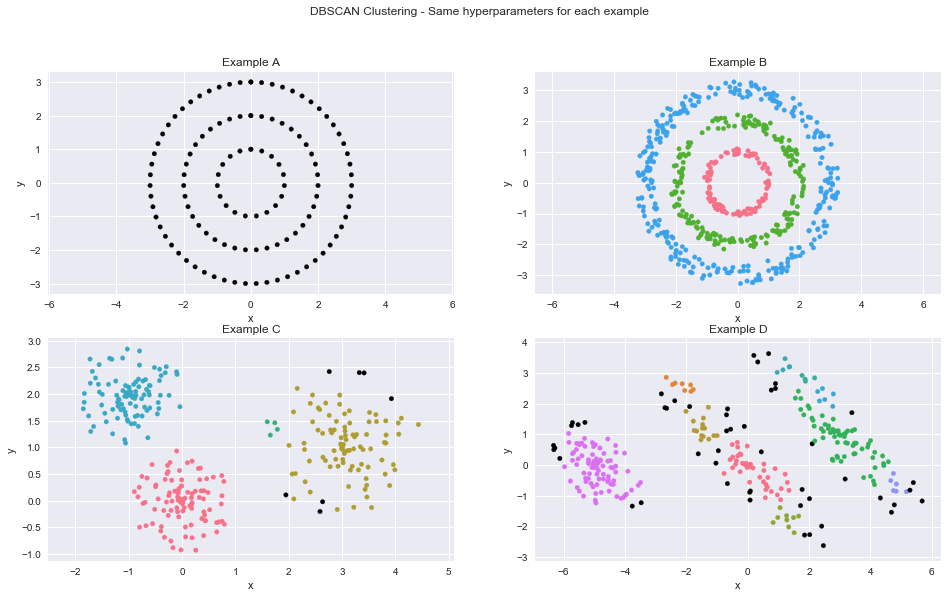

In [248]:
f, ax = plt.subplots(2, 2, figsize=(16,9))
ax = ax.flatten()

colors = sns.color_palette()

for i, example in enumerate(examples):
    labels = model.fit_predict(example)
    df = pd.DataFrame(example, columns=['x', 'y'])
    df['label'] = labels
    colors = sns.color_palette("husl", df['label'].nunique())
    df.plot('x', 'y', kind = 'scatter', ax=ax[i], c = df['label'].apply(lambda x: colors[x] if x != -1 else (0, 0, 0)))
    ax[i].axis('equal')
    ax[i].set_title("Example {}".format("ABCD"[i]))

f.suptitle("DBSCAN Clustering - Same hyperparameters for each example")

Black points were not classifed.

Example A is to sparse for my choice of epsilon and required neighbours for th center points. One set of hyper parameters cannot handle all four problems!

Example B is spot on.

In Example C the dense balls are clustered perfectly, but the less dense one is more problematic.

Example D has two pretty sparse elipses that are not clustered well.

Let's tune hyperparameters for each example to give DBSCAN a fair shot.

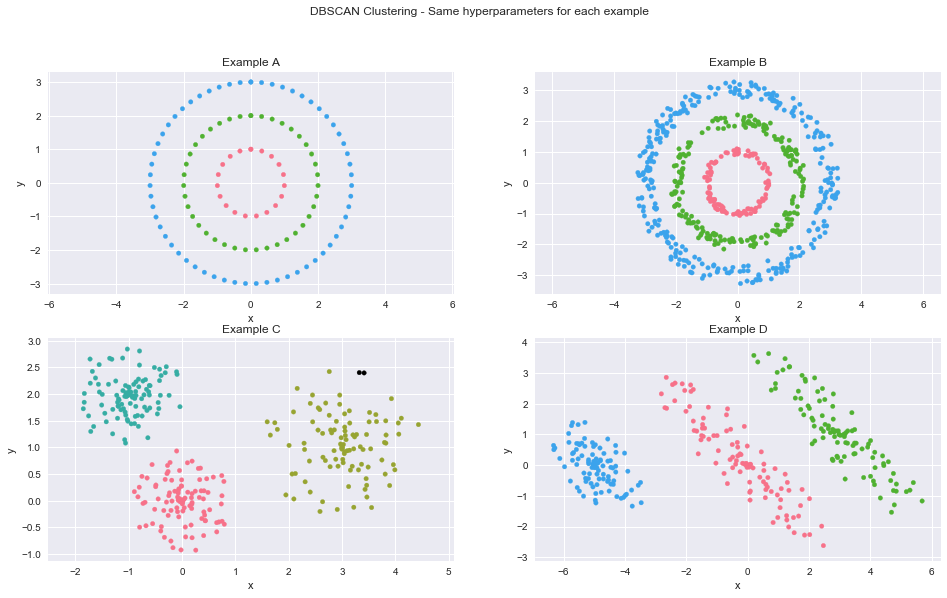

In [263]:
f, ax = plt.subplots(2, 2, figsize=(16,9))
ax = ax.flatten()

colors = sns.color_palette()

def plot_model_results(model, i):
    example = examples[i]
    labels = model.fit_predict(example)
    df = pd.DataFrame(example, columns=['x', 'y'])
    df['label'] = labels
    colors = sns.color_palette("husl", df['label'].nunique())
    df.plot('x', 'y', kind = 'scatter', ax=ax[i], c = df['label'].apply(lambda x: colors[x] if x != -1 else (0, 0, 0)))
    ax[i].axis('equal')
    ax[i].set_title("Example {}".format("ABCD"[i]))

#Example A
i = 0
model = DBSCAN(eps = .7, min_samples=2)
plot_model_results(model, i)

#Example B
i = 1
model = DBSCAN(eps = .4)
plot_model_results(model, i)

#Example C
i = 2
model = DBSCAN(eps = .5)
plot_model_results(model, i)

#Example D
i = 3
model = DBSCAN(eps = .7)
plot_model_results(model, i)

f.suptitle("DBSCAN Clustering - Same hyperparameters for each example")

Much better! The only problem I was not able to fix by tuning the hyperparameters are two unclassified points in Example C. Increasing epsilon unfortunately caused the two smalled balls to merge.

An important takeaway from this improvement is that there are no hyperparameters that will work for every data set. 
Carefully tuning them based on density and shape is necessary!

# Gaussian Mixture Models
I have never used this method before, let's try it out!

It should handle Example C and D well as they are coherent shapes. Unlike KMeans elipses are not a problem for Gaussian Mixture Models.

It should struggle with Example A and B.

In [271]:
from sklearn.mixture import GaussianMixture

In [272]:
model = GaussianMixture(3)

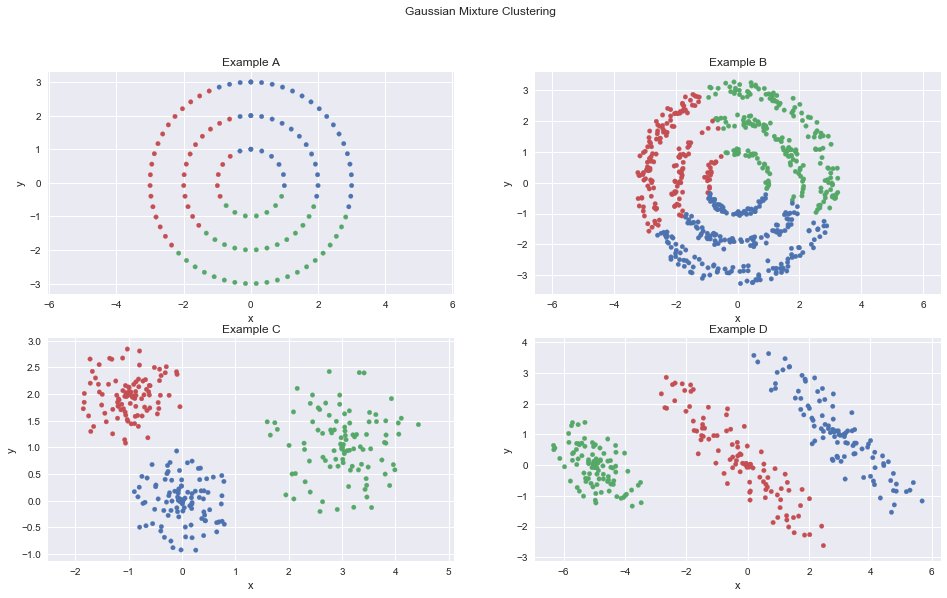

In [276]:
f, ax = plt.subplots(2, 2, figsize=(16,9))
ax = ax.flatten()

colors = sns.color_palette()

for i, example in enumerate(examples):
    model.fit(example)
    labels = model.predict(example)
    df = pd.DataFrame(example, columns=['x', 'y'])
    df['label'] = labels
    df.plot('x', 'y', kind = 'scatter', ax=ax[i], c = df['label'].apply(lambda x: colors[x]))
    ax[i].axis('equal')
    ax[i].set_title("Example {}".format("ABCD"[i]))

f.suptitle("Gaussian Mixture Clustering")